In [24]:
import time
from functools import partial
from typing import Callable

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray
from jax.scipy import stats

from bpd import DATA_DIR
from bpd.chains import run_sampling_nuts, run_warmup_nuts
from bpd.draw import draw_gaussian
from bpd.prior import ellip_prior_e1e2
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_target_galaxy_params_simple,
)

import matplotlib.pyplot as plt

In [10]:
def logprior(
    params: dict[str, Array],
    *,
    sigma_e: float,
    sigma_x: float = 0.5,  # pixels
    flux_bds: tuple = (-1.0, 9.0),
    hlr_bds: tuple = (0.01, 5.0),
) -> Array:
    prior = jnp.array(0.0)

    f1, f2 = flux_bds
    prior += stats.uniform.logpdf(params["lf"], f1, f2 - f1)

    h1, h2 = hlr_bds
    prior += stats.uniform.logpdf(params["hlr"], h1, h2 - h1)

    prior += stats.norm.logpdf(params["x"], loc=0.0, scale=sigma_x)
    prior += stats.norm.logpdf(params["y"], loc=0.0, scale=sigma_x)

    e1e2 = jnp.stack((params["e1"], params["e2"]), axis=-1)
    prior += jnp.log(ellip_prior_e1e2(e1e2, sigma=sigma_e))

    return prior

In [11]:
def loglikelihood(
    params: dict[str, Array],
    data: Array,
    *,
    draw_fnc: Callable,
    background: float,
):
    _draw_params = {**params}
    _draw_params["f"] = 10 ** _draw_params.pop("lf")
    model = draw_fnc(**_draw_params)
    likelihood_pp = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(background))
    return jnp.sum(likelihood_pp)


def _init_fnc(image: Array):
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()
    hlr = 0.95  # median size
    e1 = 0.0
    e2 = 0.0
    x = 0.0
    y = 0.0
    return {"lf": jnp.log10(flux), "hlr": hlr, "e1": e1, "e2": e2, "x": x, "y": y}


def logtarget(
    params: dict[str, Array],
    data: Array,
    *,
    logprior_fnc: Callable,
    loglikelihood_fnc: Callable,
):
    return logprior_fnc(params) + loglikelihood_fnc(params, data)


def sample_prior(
    rng_key: PRNGKeyArray,
    *,
    shape_noise: float,
    mean_logflux: float = 2.6,
    sigma_logflux: float = 0.4,
    hlr_bds: tuple[float, float] = (0.7, 1.2),
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2, k3 = random.split(rng_key, 3)

    lf = random.normal(k1) * sigma_logflux + mean_logflux
    hlr = random.uniform(k2, minval=hlr_bds[0], maxval=hlr_bds[1])
    other_params = sample_target_galaxy_params_simple(
        k3, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "hlr": hlr, **other_params}

In [12]:
rng_key = random.key(42)
k1, k2, k3 = random.split(rng_key, 3)

In [13]:
slen = 63
fft_size = 256
shape_noise = 0.3
sigma_e_int = 0.4
background = 1.0

In [14]:
# setup target density
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(loglikelihood, draw_fnc=draw_fnc, background=background)
_logprior = partial(logprior, sigma_e=sigma_e_int)
_logtarget = partial(
    logtarget, logprior_fnc=_logprior, loglikelihood_fnc=_loglikelihood
)

In [17]:
# setup nuts functions
_run_warmup1 = partial(
    run_warmup_nuts,
    logtarget=_logtarget,
    initial_step_size=0.1,
    max_num_doublings=5,
    n_warmup_steps=500,
)
_run_warmup = vmap(jit(_run_warmup1))

_run_sampling1 = partial(
    run_sampling_nuts,
    logtarget=_logtarget,
    n_samples=200,
    max_num_doublings=5,
)
_run_sampling = vmap(jit(_run_sampling1))

In [18]:
n_gals = 10

In [20]:
k1s = random.split(k1, n_gals)
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(k1s)

In [22]:
# get images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)

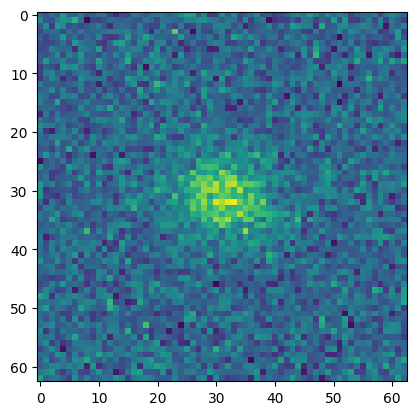

In [30]:
plt.imshow(target_images[9])

In [35]:
# # initialize positions
# init_positions = vmap(_init_fnc)(target_images)
# init_positions, galaxy_params

({'e1': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
  'e2': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
  'hlr': Array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95],      dtype=float64, weak_type=True),
  'lf': Array([2.38970726, 2.01077205, 2.68182783, 3.09255868, 2.21471423,
         2.7988639 , 3.19258205, 3.02693035, 2.54109748, 2.85379967],      dtype=float64),
  'x': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
  'y': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True)},
 {'e1': Array([-0.13730287,  0.34650732, -0.18141658,  0.04518224,  0.1091972 ,
          0.14563153, -0.3166311 , -0.20418099,  0.01199936,  0.13784756],      dtype=float64),
  'e2': Array([-0.13492882, -0.11909088, -0.1907017 , -0.18514793,  0.06411043,
          0.13044872, -0.04551223, -0.6180162 , -0.22342223,  0.1649657 ],      dtype=float64),
  'g1': Array([0.

In [44]:
init_positions = vmap(get_true_params_from_galaxy_params)(galaxy_params)

In [45]:
init_positions

{'e1': Array([-0.11725889,  0.36426258, -0.16126938,  0.06580685,  0.12899729,
         0.16548775, -0.29847932, -0.17720725,  0.0329889 ,  0.15795316],      dtype=float64),
 'e2': Array([-0.13561767, -0.1174096 , -0.19201348, -0.18473731,  0.06380568,
         0.12963937, -0.0460757 , -0.62274962, -0.22322125,  0.16399244],      dtype=float64),
 'hlr': Array([0.85162797, 1.08727508, 0.7175488 , 1.061069  , 1.01220836,
        1.10519897, 1.10178552, 1.18106628, 1.1012382 , 1.02441114],      dtype=float64),
 'lf': Array([2.44387667, 2.29318242, 2.71613174, 3.11051695, 2.32917254,
        2.7949633 , 3.18331156, 3.02307659, 2.55491694, 2.87832373],      dtype=float64),
 'x': Array([-0.28585416, -0.44258088,  0.24662322,  0.06594777,  0.28199315,
         0.08823019,  0.46014224,  0.18794353,  0.30843203,  0.37212524],      dtype=float64),
 'y': Array([-2.66140416e-01, -3.84976143e-01, -1.33743499e-01, -3.20456893e-01,
        -1.67905214e-04,  2.60592934e-01,  1.41592022e-01,  2.7934455

In [46]:
k2s = random.split(k2, n_gals)
k3s = random.split(k3, n_gals)

In [47]:
init_states, tuned_params, adapt_info = _run_warmup(
    k2s, init_positions, target_images
)

In [48]:
tuned_params.pop("max_num_doublings")  # set above, not jittable
samples, _ = _run_sampling(k3s, init_states, tuned_params, target_images)


In [49]:
samples

{'e1': Array([[-0.25219342, -0.25940391, -0.29680981, ..., -0.2510121 ,
         -0.21409468, -0.31573559],
        [ 0.07938479,  0.0167728 ,  0.03482818, ...,  0.18612997,
          0.13827889,  0.25903559],
        [-0.19734884, -0.12043677, -0.18549889, ..., -0.20486039,
         -0.12539316, -0.21314024],
        ...,
        [-0.21215237, -0.19414747, -0.2180079 , ..., -0.18410329,
         -0.21097291, -0.20085457],
        [-0.06120438,  0.03309582,  0.07334841, ..., -0.07140671,
          0.13122389, -0.08297709],
        [ 0.11603707,  0.14511894,  0.16598748, ...,  0.15151655,
          0.10852876,  0.11779359]], dtype=float64),
 'e2': Array([[-0.1429302 , -0.16454125, -0.17571172, ..., -0.15960772,
         -0.10187335, -0.14977726],
        [-0.22635718, -0.28837774, -0.23334168, ..., -0.16252346,
          0.09876281, -0.22663748],
        [-0.15232007, -0.14952801, -0.11176003, ..., -0.11890495,
         -0.18636206, -0.1536558 ],
        ...,
        [-0.64411352, -0.64

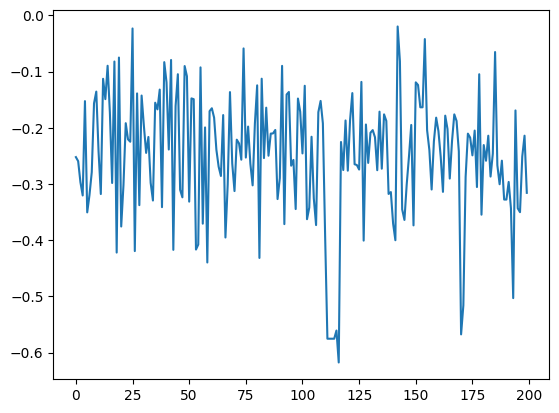

In [51]:
plt.plot(samples['e1'][0, :])

In [ ]:
        # warmup
        t1 = time.time()

        t2 = time.time()
        t_warmup = t2 - t1

        # inference
        t1 = time.time()
        t2 = time.time()
        t_sampling = t2 - t1

        true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)

        results[n_gals] = {}
        results[n_gals]["t_warmup"] = t_warmup
        results[n_gals]["t_sampling"] = t_sampling
        results[n_gals]["samples"] = samples
        results[n_gals]["truth"] = true_params
        results[n_gals]["adapt_info"] = adapt_info
        results[n_gals]["tuned_params"] = tuned_params

    jnp.save(fpath, results)

## Check exp21 samples

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"


In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt 
ds = jnp.load("/pscratch/sd/i/imendoza/data/cache_chains/exp21_42/chain_results_42.npy", allow_pickle=True).item()

In [15]:
ds.keys()

dict_keys([1, 5, 10])

In [16]:
ds[10]['samples']['e1'].shape

(10, 4, 500)

In [17]:
ds[10]['truth']['e1'].shape

(10,)

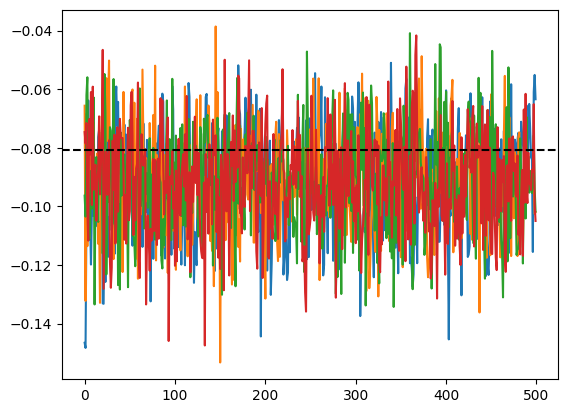

In [44]:
idx = 9
for ii in range(4): 
    plt.plot(ds[10]['samples']['lhlr'][idx, ii])
plt.axhline(ds[10]['truth']['lhlr'][idx], linestyle='--', color='k')


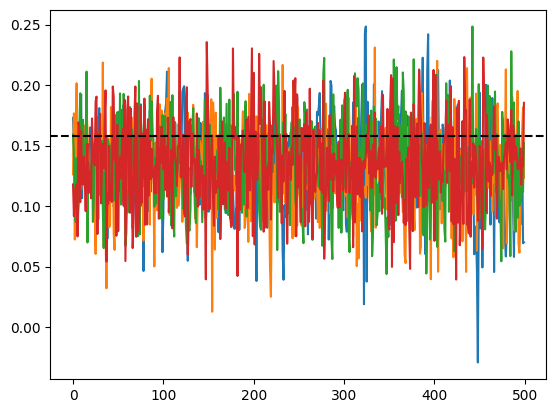

In [25]:
idx = 9
for ii in range(4): 
    plt.plot(ds[10]['samples']['e1'][idx, ii])
plt.axhline(ds[10]['truth']['e1'][idx], linestyle='--', color='k')


In [ ]:
idx = 0
for ii in range(4): 
    plt.plot(ds[10]['samples']['lf'][idx, ii])
plt.axhline(0.0, linestyle='--', color='k')


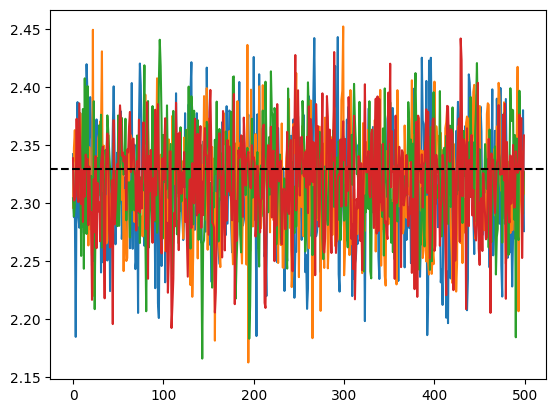

In [38]:
idx = 4
for ii in range(4): 
    plt.plot(ds[10]['samples']['lf'][idx, ii])
plt.axhline(ds[10]['truth']['lf'][idx], linestyle='--', color='k')


In [26]:
ds[10]['truth'].keys()

dict_keys(['e1', 'e2', 'lf', 'lhlr', 'x', 'y'])